<div style="width: 100%; background-color: rgb(11,94,132); border: 3px solid #666666; text-align: center; color:rgb(248, 248, 248); border-radius:6px; padding: 10px 0 8px 0;">
    <h1 style="color:rgb(255,255,255);font-weight: bold; margin-bottom: 8px;">🏀 NBA Players Performance 🏀</h1>
    <span style="font-size: 18px; font-style: italic;">Machine Learning | Points Prediction</span>
</div>


<div style="width: 100%; background-color: rgb(11, 94, 132); color: white; padding: 5px; border: 3px solid #666666; margin-bottom: 5px;border-radius:5px;">
    <h3 style="color: #161616;">Introduction</h3>
<span>This notebook focuses on analyzing NBA player performance data and projecting player points using machine learning techniques. 
Predicting basketball points for each player is of utmost importance in the world of basketball analytics. It serves as a crucial performance metric that allows coaches, analysts, and fans to assess a player's scoring ability and overall offensive contribution to the team. Understanding players' scoring potential aids in strategic decision-making during games, player selection, and talent scouting. In this notebook, we delve into the realm of basketball data analytics and employ various machine learning techniques to predict players' point contributions</span>
<br>
<br>
<h4>The workflow includes:</h4>

1. **Data Loading**:
    - Import and inspect datasets containing NBA box scores, game details, and player statistics.
    - Merge datasets as needed for analysis.

2.  **Data Exploration (EDA) and Cleaning**:
    - Perform exploratory data analysis (EDA) to understand the structure and distribution of the data.
    - Analyze player performance metrics such as points, assists, rebounds, and shooting percentages.
    - Visualize data distributions and correlations between features.

3. **Preprocessing the data**:
    - Prepare the Dataframe: Handle missing values and clean the datasets to ensure consistency.
    - Add some features (only  numericals) like avg_points_vs_opponent, avg_pts_opp_position
    - Derive Per-36-Minute and Per-Possession Rates
    - Scale Features (normalize)

4. **Model Training & Evaluation**:
    - Prepare data for machine learning by selecting relevant features.
    - Modeling: 
        - XGBboost : Extreme Gradient Boosting
        - LightGBM : Light Gradient-Boosting Machine
        - RandomForestRegressor : Classifying decision trees 
    - Train and evaluate models to predict player statistics for future games.
    - Choose the most performant model
    - Visual Comparison of Predicted vs. Actual Points
    - Save the Model


This notebook serves as a comprehensive guide for analyzing NBA data and leveraging machine learning to gain actionable insights into player performance.


In [27]:
# First of all, import the necessary libraries 
# Librairies for data manipulation and analysis
import pandas as pd
from math import ceil
import numpy as np

# Libraries for machine learning
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import joblib 
# Libraries for model evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Libraries for feature importance
import shap 

# Libraries for warnings management
import warnings

## 1. Load and Merge Data

In this section, we load all the required datasets: basic boxscore, advanced boxscore statistics, player metadata, and team information. These data sources are essential to build a comprehensive understanding of player performance and to engineer features that can help us predict fantasy scores.

### 1.1 Load Datasets

In [2]:
# Load raw boxscore and advanced boxscore data
boxscore_df = pd.read_csv('../../databases/nba_boxscore_basic.csv', low_memory=False)
advanced_boxscore = pd.read_csv('../../databases/nba_boxscore_advanced.csv', low_memory=False)
players_df = pd.read_csv('../../databases/nba_players_df_2024-25.csv')
nba_teams_df = pd.read_csv('../../databases/nba_teams_df.csv')

print(f"Boxscore: {boxscore_df.shape}, Advanced Boxscore: {advanced_boxscore.shape}, Players: {players_df.shape}, Teams: {nba_teams_df.shape}")

Boxscore: (34372, 45), Advanced Boxscore: (34372, 48), Players: (575, 26), Teams: (30, 7)


### 1.2 Inspect Column Structures

In [3]:
print("\nBoxscore Columns:")
print(boxscore_df.columns.tolist())

print("\nAdvanced Boxscore Columns:")
print(advanced_boxscore.columns.tolist())

print("\nPlayers Columns:")
print(players_df.columns.tolist())

print("\nTeams Columns:")
print(nba_teams_df.columns.tolist())


Boxscore Columns:
['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug', 'personId', 'firstName', 'familyName', 'nameI', 'playerSlug', 'position', 'comment', 'jerseyNum', 'minutes', 'fieldGoalsMade', 'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade', 'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade', 'freeThrowsAttempted', 'freeThrowsPercentage', 'reboundsOffensive', 'reboundsDefensive', 'reboundsTotal', 'assists', 'steals', 'blocks', 'turnovers', 'foulsPersonal', 'points', 'plusMinusPoints', 'game_id', 'is_regular_season', 'is_playoffs', 'playoffs_desc', 'game_date', 'home_team_id', 'home_team_tricode', 'visitor_team_id', 'visitor_team_tricode', 'game_status', 'game_status_text']

Advanced Boxscore Columns:
['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug', 'personId', 'firstName', 'familyName', 'nameI', 'playerSlug', 'position', 'comment', 'jerseyNum', 'minutes', 'estimatedOffensiveRating', 'offensiveRating',

### 1.3 Merge All Data Into One DataFrame

In [4]:
# 1. Merge player metadata (keep only relevant columns)
full_df = boxscore_df.merge(
    players_df[['PERSON_ID', 'HEIGHT', 'WEIGHT', 'POSITION']],
    left_on='personId', right_on='PERSON_ID', how='left'
).drop('PERSON_ID', axis=1)

# 2. Merge advanced stats, keeping only new columns
# Find columns in advanced_boxscore that are not in boxscore_df (except keys)
merge_keys = ['game_id', 'personId', 'teamId']
adv_new_cols = [col for col in advanced_boxscore.columns if col not in boxscore_df.columns or col in merge_keys]

full_df = full_df.merge(
    advanced_boxscore[adv_new_cols],
    on=merge_keys, how='left'
)

In [5]:
print(f"Final merged DataFrame: {full_df.shape}")
print("\full_df Columns:")
print(full_df.columns)

Final merged DataFrame: (34372, 70)
ull_df Columns:
Index(['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug',
       'personId', 'firstName', 'familyName', 'nameI', 'playerSlug',
       'position', 'comment', 'jerseyNum', 'minutes', 'fieldGoalsMade',
       'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade',
       'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade',
       'freeThrowsAttempted', 'freeThrowsPercentage', 'reboundsOffensive',
       'reboundsDefensive', 'reboundsTotal', 'assists', 'steals', 'blocks',
       'turnovers', 'foulsPersonal', 'points', 'plusMinusPoints', 'game_id',
       'is_regular_season', 'is_playoffs', 'playoffs_desc', 'game_date',
       'home_team_id', 'home_team_tricode', 'visitor_team_id',
       'visitor_team_tricode', 'game_status', 'game_status_text', 'HEIGHT',
       'WEIGHT', 'POSITION', 'estimatedOffensiveRating', 'offensiveRating',
       'estimatedDefensiveRating', 'defensiveRating', 'esti

## 2. Exploratory Data Analysis (EDA)

We perform EDA to understand the structure, distribution, and relationships within our dataset. This includes:
- Identifying missing values: Counting and visualizing missing data.
- Examining categorical variable distributions
- Generating summary statistics for numerical variables
- Exploring pairwise correlations
- Visualizing the relationship between minutes played and fantasy points

### 2.1 Identifying missing values + duplicates 
- Counting and visualizing missing data.
- Counting duplicate rows

In [6]:
# 2.1 Identiying NaN values and duplicates
pd.set_option('display.max_columns', None)  # Show all columns in output
print("\nNaN values in full_df:")
full_df_nan = full_df.isna().sum().sort_values(ascending=False)
print(full_df_nan)
print("\nDuplicates in full_df:")
duplicates = full_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


NaN values in full_df:
jerseyNum          34372
playoffs_desc      32515
comment            27681
position           21422
minutes             6691
                   ...  
foulsPersonal          0
points                 0
plusMinusPoints        0
game_id                0
PIE                    0
Length: 70, dtype: int64

Duplicates in full_df:
Number of duplicate rows: 0


#### NaN Analysis and Decisions

1. **START_POSITION**:
    - Missing values: 19,296
    - Decision: This column might be important for analyzing player roles. Consider imputing missing values with "Bench" or "Unknown" if applicable. 

2. **COMMENT**:
    - Missing values: 25,158
    - Decision: This column seems to contain qualitative data. If not critical for analysis, it can be dropped. Otherwise, explore if missing values can be filled with a default comment like "No Comment".

3. **MIN (Minutes Played)**:
    - Missing values: 5,888
    - Decision: Missing values in this column could indicate players who did not participate in the game. Consider imputing with "0:00" or filtering out such rows if they are not relevant to the analysis.

4. **Players Metadata**:
    - Missing values: 5k+ 
    - Decision: These metrics are likely missing for players who are not present in the players_df database, so first investigate why 

Lets do more analysis before taking decision 

### 2.2 Inspect Categorical Variables

 EDA charts for categorical variables


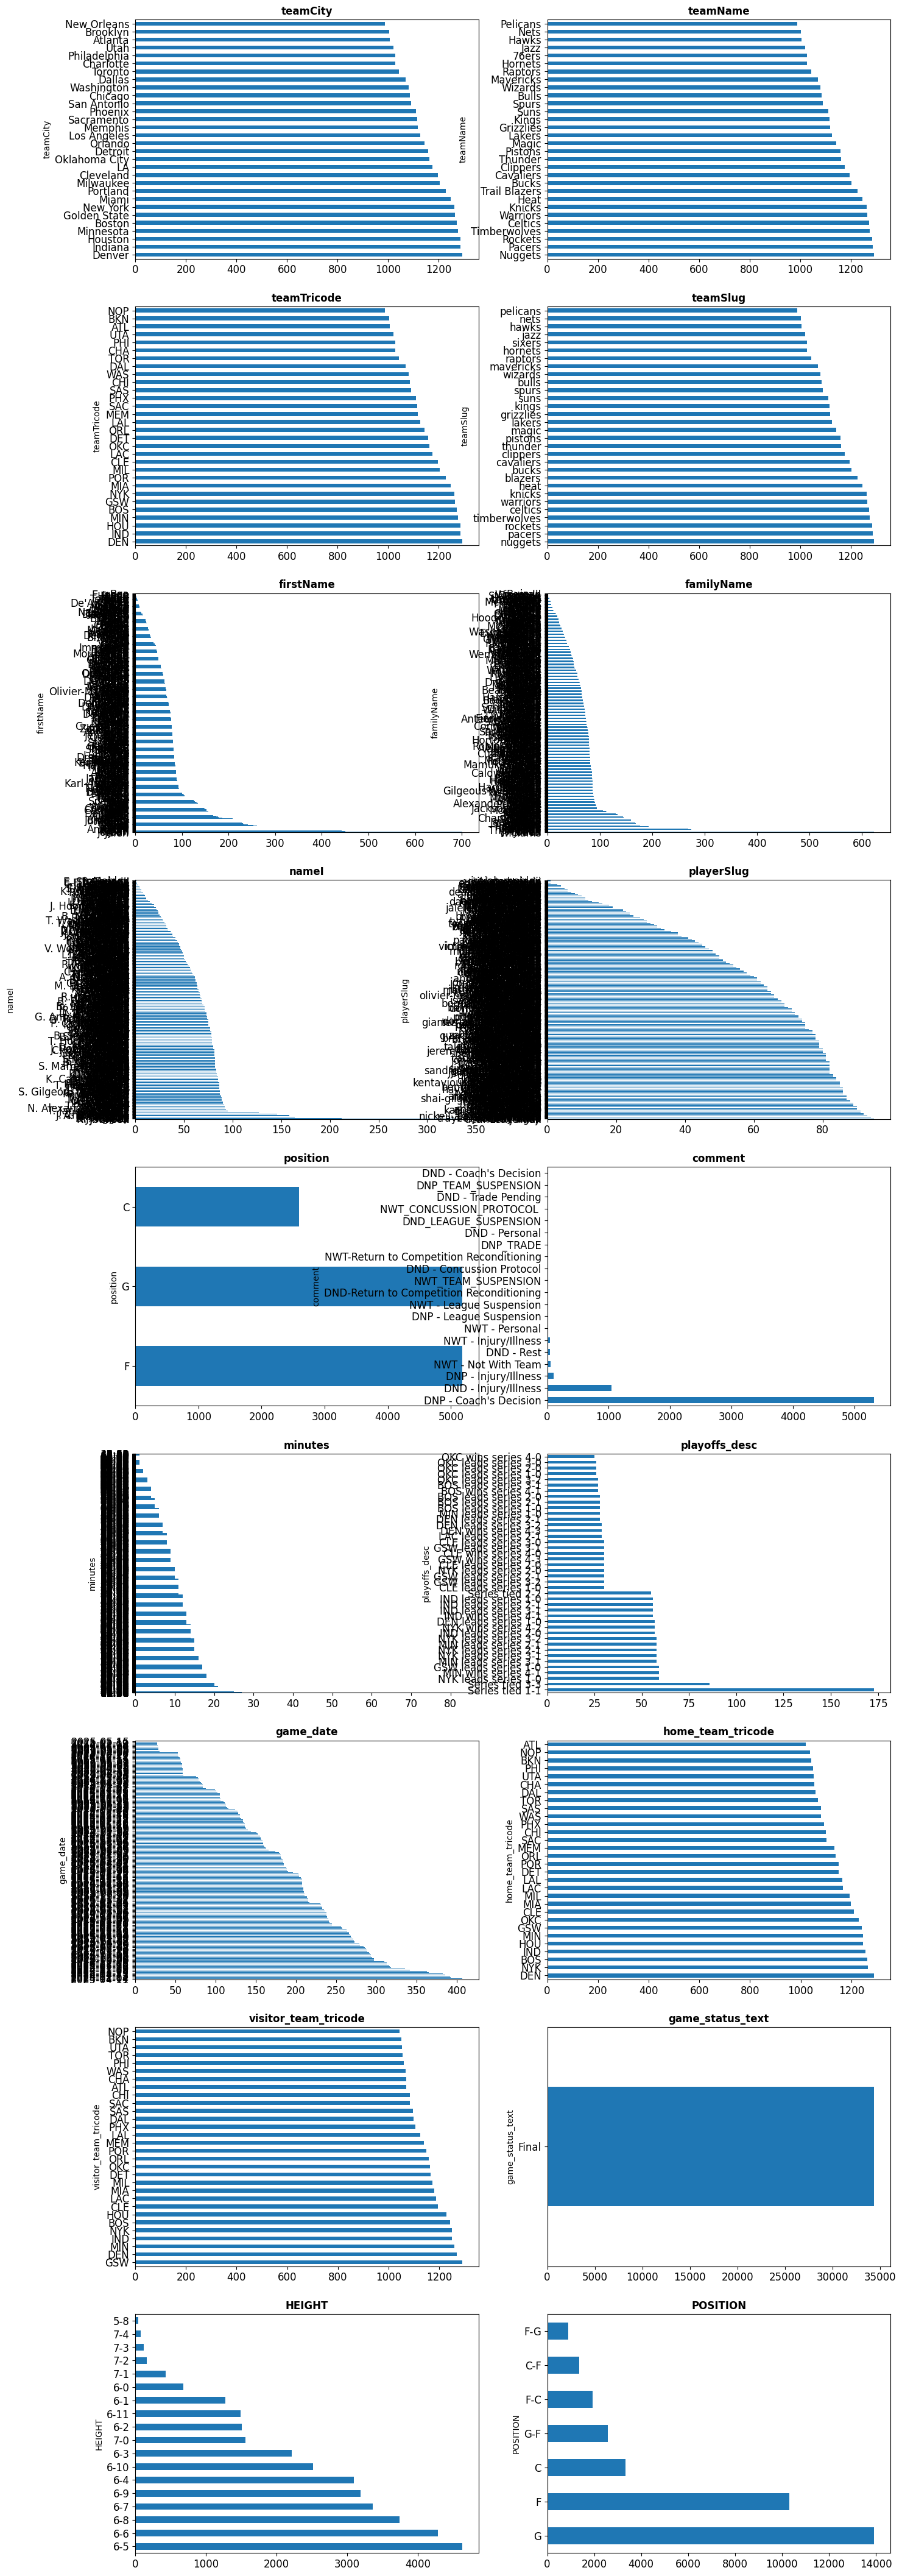

In [12]:
def category_eda_charts(cat):
    rows = ceil(cat.shape[1] / 2)
    f, ax = plt.subplots(nrows=rows, ncols=2, figsize=(16, rows * 6))
    ax = ax.flat
    for i, col in enumerate(cat):
        cat[col].value_counts().plot.barh(ax=ax[i])
        ax[i].set_title(col, fontsize=12, fontweight="bold")
        ax[i].tick_params(labelsize=12)
category_eda_charts(full_df.select_dtypes('O'))
print(" EDA charts for categorical variables") 

#### Conclusion : 
- "minutes" Column should be int 
- Comments column is only to justify that the player is not playing, so we can remove this column + remove rows where this column is not blank
- For Height column, should be used for deep ML model but for the moment we will keep it simple so we can remove this feature
- 2 columns Positions, one from the boxscore and one from the playerindex df. We can create a new column position with only 3 positions available : G,F,C. 
- We can modify game_date column from string to datetime format
- To see : Add a Season column to potential future time decay

### 2.3 Descriptive Statistics

**For :**  
- Advanced Boxscore
- Boxscore

In [13]:
def continuous_statistics(num):
    # Calculate basic descriptive statistics using .describe()
    # This includes: count, mean, std, min, 25%, 50%, 75%, max
    statistics = num.describe().T  # Transpose to get variables as rows

    # Add the median manually (even though .describe() includes 50%, this is for clarity or comparison)
    statistics['median'] = num.median()

    # Reorder the columns so that 'median' appears next to 'mean'
    statistics = statistics.iloc[:, [0, 1, 8, 2, 3, 4, 5, 6, 7]]

    # Return the final DataFrame of statistics
    return statistics

print(" EDA charts for numerical variables")
continuous_statistics(full_df.select_dtypes('number'))

 EDA charts for numerical variables


count          mean        median  \
gameId                        34372.0  2.348112e+07  2.240065e+07   
teamId                        34372.0  1.610613e+09  1.610613e+09   
personId                      34372.0  1.401089e+06  1.630178e+06   
jerseyNum                         0.0           NaN           NaN   
fieldGoalsMade                34372.0  3.130600e+00  2.000000e+00   
fieldGoalsAttempted           34372.0  6.710782e+00  6.000000e+00   
fieldGoalsPercentage          34372.0  3.456377e-01  3.750000e-01   
threePointersMade             34372.0  1.016438e+00  0.000000e+00   
threePointersAttempted        34372.0  2.824421e+00  2.000000e+00   
threePointersPercentage       34372.0  2.140957e-01  0.000000e+00   
freeThrowsMade                34372.0  1.276562e+00  0.000000e+00   
freeThrowsAttempted           34372.0  1.638107e+00  0.000000e+00   
freeThrowsPercentage          34372.0  3.356328e-01  0.000000e+00   
reboundsOffensive             34372.0  8.378331e-01  0.000000e+00   
reboundsDefensive             34372.0  2.481700e+00  2.000000e+00   
reboundsTotal                 34372.0  3.319533e+00  2.000000e+00   
assists                       34372.0  1.986413e+00  1.000000e+00   
steals                        34372.0  6.159374e-01  0.000000e+00   
blocks                        34372.0  3.676830e-01  0.000000e+00   
turnovers                     34372.0  1.014721e+00  1.000000e+00   
foulsPersonal                 34372.0  1.408094e+00  1.000000e+00   
points                        34372.0  8.554201e+00  6.000000e+00   
plusMinusPoints               34372.0 -8.728034e-05  0.000000e+00   
game_id                       34372.0  2.348112e+07  2.240065e+07   
home_team_id                  34372.0  1.610613e+09  1.610613e+09   
visitor_team_id               34372.0  1.610613e+09  1.610613e+09   
game_status                   34372.0  3.000000e+00  3.000000e+00   
WEIGHT                        34278.0  2.157764e+02  2.150000e+02   
estimatedOffensiveRating      34372.0  8.782810e+01  1.046000e+02   
offensiveRating               34372.0  8.766968e+01  1.050000e+02   
estimatedDefensiveRating      34372.0  8.935300e+01  1.056000e+02   
defensiveRating               34372.0  8.935789e+01  1.060000e+02   
estimatedNetRating            34372.0 -1.524639e+00  0.000000e+00   
netRating                     34372.0 -1.688447e+00  0.000000e+00   
assistPercentage              34372.0  1.182479e-01  7.950000e-02   
assistToTurnover              34372.0  9.110023e-01  0.000000e+00   
assistRatio                   34372.0  1.408364e+01  1.110000e+01   
offensiveReboundPercentage    34372.0  3.620837e-02  0.000000e+00   
defensiveReboundPercentage    34372.0  1.048935e-01  8.600000e-02   
reboundPercentage             34372.0  7.077610e-02  5.900000e-02   
turnoverRatio                 34372.0  7.930627e+00  3.050000e+00   
effectiveFieldGoalPercentage  34372.0  4.021811e-01  4.410000e-01   
trueShootingPercentage        34372.0  4.259655e-01  5.000000e-01   
usagePercentage               34372.0  1.459650e-01  1.520000e-01   
estimatedUsagePercentage      34372.0  1.504852e-01  1.570000e-01   
estimatedPace                 34372.0  8.186005e+01  9.915000e+01   
pace                          34372.0  8.307577e+01  9.885000e+01   
pacePer40                     34372.0  6.922976e+01  8.237000e+01   
possessions                   34372.0  3.811393e+01  4.100000e+01   
PIE                           34372.0  7.261600e-02  6.700000e-02   

                                       std           min           25%  \
gameId                        4.521366e+06  2.240000e+07  2.240032e+07   
teamId                        8.538180e+00  1.610613e+09  1.610613e+09   
personId                      5.277588e+05  2.544000e+03  1.628365e+06   
jerseyNum                              NaN           NaN           NaN   
fieldGoalsMade                3.300214e+00  0.000000e+00  0.000000e+00   
fieldGoalsAttempted           6.359896e+00  0.000000e+00  1.000000e+

#### Conclusion : 
- We can remove jerseyNumb column, not revelant and empty 
- We can add a column "Opponent" to have the Opponant team_id 
- We add a column "isHome" to flag home/away 

### 2.4 Heatmap 

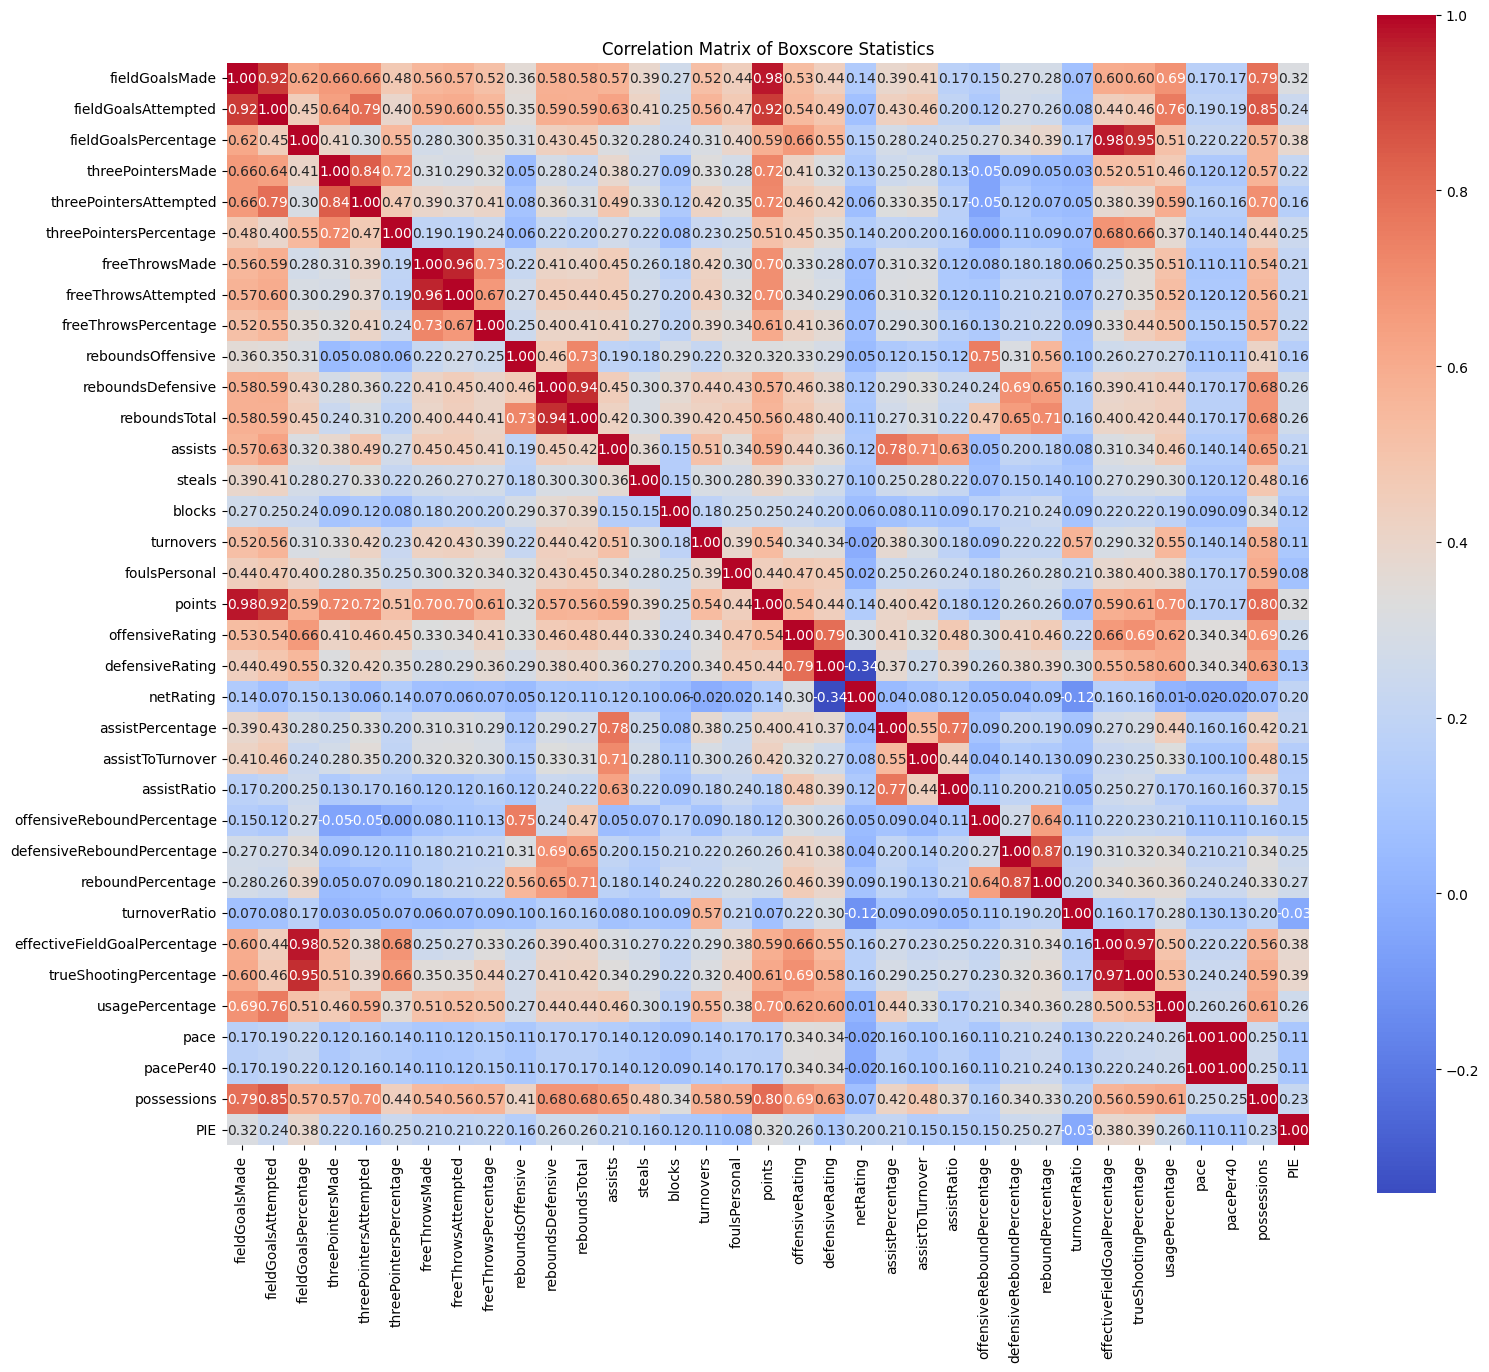

In [15]:
# Correlation Matrix 
# Select only numerical columns
# numerical_columns = full_df.select_dtypes(include=['float64', 'int64']).columns
selected_columns = [
    'fieldGoalsMade', 'fieldGoalsAttempted', 'fieldGoalsPercentage',
    'threePointersMade', 'threePointersAttempted', 'threePointersPercentage',
    'freeThrowsMade', 'freeThrowsAttempted', 'freeThrowsPercentage',
    'reboundsOffensive', 'reboundsDefensive', 'reboundsTotal',
    'assists', 'steals', 'blocks', 'turnovers', 'foulsPersonal', 'points',
    'offensiveRating', 'defensiveRating', 'netRating',
    'assistPercentage', 'assistToTurnover', 'assistRatio',
    'offensiveReboundPercentage', 'defensiveReboundPercentage',
    'reboundPercentage', 'turnoverRatio', 'effectiveFieldGoalPercentage',
    'trueShootingPercentage', 'usagePercentage', 'pace', 'pacePer40',
    'possessions', 'PIE'
]

# Set the size of the figure
plt.figure(figsize=(16, 16))
# Create a heatmap using seaborn
sns.heatmap(full_df[selected_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Boxscore Statistics')
plt.tight_layout()
plt.show()

#### Conclusion

---

##### 1. Volume-Driven Trends (vs. Possessions)

- **Points vs. Possessions**  
  More team possessions generally give a player more scoring opportunities. You’ll see a strong positive trend—players logging high-possession roles (e.g., primary ball-handlers) rack up points almost in lockstep with possession share, though outliers occur when a player is inefficient or shares scoring.

- **ReboundsTotal vs. Possessions**  
  Pace drives rebounding volume. Faster games (more possessions) inflate raw rebound totals across the board. Expect a clear upward slope, but with tighter clusters for true glass-cleaners (e.g., centers) versus perimeter players.

- **Assists vs. Possessions**  
  Similar to scoring, players with higher possession shares tend to accumulate assists. Point guards in high‐usage schemes will lie along the top of this band, while low‐usage role players cluster near the bottom.

- **Steals vs. Possessions**  
  More possessions mean more defensive opportunities—and hence more chances for steals. The relationship is positive but weaker: defensive hunting styles and minutes played introduce more dispersion.

- **Turnovers vs. Possessions**  
  Also a positively sloped “band,” since more touches often equal more giveaways. Unlike points and assists, this slope is unwelcome—ideally, you seek players who over‐perform on counting stats relative to their turnovers.

---

##### 2. Rate-Based Insights

- **Points vs. UsagePercentage**  
  Usage% controls for pace/role: high‐usage players generally score more, but efficiency matters. You’ll see a rising curve with increasing variance—the stars score at will, but high‐usage inefficients can underperform their usage slot.

- **ReboundsTotal vs. ReboundPercentage**  
  Rebound% neutralizes pace by measuring share of available boards. Expect a tight positive trend: players with 15–20% rebound rates reliably post double‐digit rebound totals, regardless of team pace.

- **Assists vs. AssistPercentage**  
  Assist% (share of teammate field goals you assisted) maps closely to raw assists. The scatter will show a strong linear cluster, with elite passers (high %) clearly separated from secondary facilitators.

---

##### 3. Efficiency Ratios & Composite Metrics

- **Assists vs. AssistToTurnover**  
  The assist-to-turnover ratio captures passing efficiency. On a scatter plot, you’ll see that high raw assists don’t always coincide with great ratios—some high-volume distributors also turn the ball over. The “sweet spot” is in the upper-right quadrant: players who both rack up assists and protect the rock.

- **Assists vs. AssistRatio**  
  Assist Ratio (estimated assists per 100 possessions used) further contextualizes playmaking. It compacts volume and efficiency into one metric. The trend is positive but exhibits “curvature”: at very high assist ratios, raw assists plateau since you’re limited by minutes and team field-goal opportunities.

---

#### Key Takeaways

1. **Volume metrics (possessions) are powerful predictors** of raw counting stats—but always check efficiency/rates to avoid misleading “empty volume.”  
2. **Rate stats (usage%, rebound%, assist%) normalize for context**, giving a cleaner view of true skill—ideal for cross‐player comparisons.  
3. **Composite ratios (AST/TO, assist ratio) reveal balance**: look for players who not only accumulate counting stats but do so efficiently.

By combining volume and rate analyses, you can identify high‐upside fantasy targets—players who do a lot with each opportunity and minimize the negatives.  


### 2.5\ Analysis of the relationship found in the correlation matrix

In [ ]:
# Select top features from correlation matrix for visual inspection
relationships = [
    ('points', 'possessions'),
    ('points', 'usagePercentage'),
    ('reboundsTotal', 'possessions'),
    ('reboundsTotal', 'reboundPercentage'),
    ('assists', 'possessions'),
    ('assists', 'assistPercentage'),
    ('assists', 'assistToTurnover'),
    ('assists', 'assistRatio'),
    ('steals', 'possessions'),
    ('turnovers', 'possessions')
]

# Create 4x3 subplots to fit all 10 relationships
fig = make_subplots(rows=4, cols=3)

for idx, (x_col, y_col) in enumerate(relationships, start=1):
    row = (idx - 1) // 3 + 1
    col = (idx - 1) % 3 + 1
    fig.add_trace(go.Scatter(
        x=full_df[x_col], 
        y=full_df[y_col], 
        mode='markers', 
        marker=dict(opacity=0.6)
    ), row=row, col=col)

    fig.update_xaxes(title_text=x_col, row=row, col=col)
    fig.update_yaxes(title_text=y_col, row=row, col=col)

fig.update_layout(
    title_text='Top Correlated Features',
    height=1000,
    width=1000,
    template='plotly_dark',
    showlegend=False
)

fig.show()

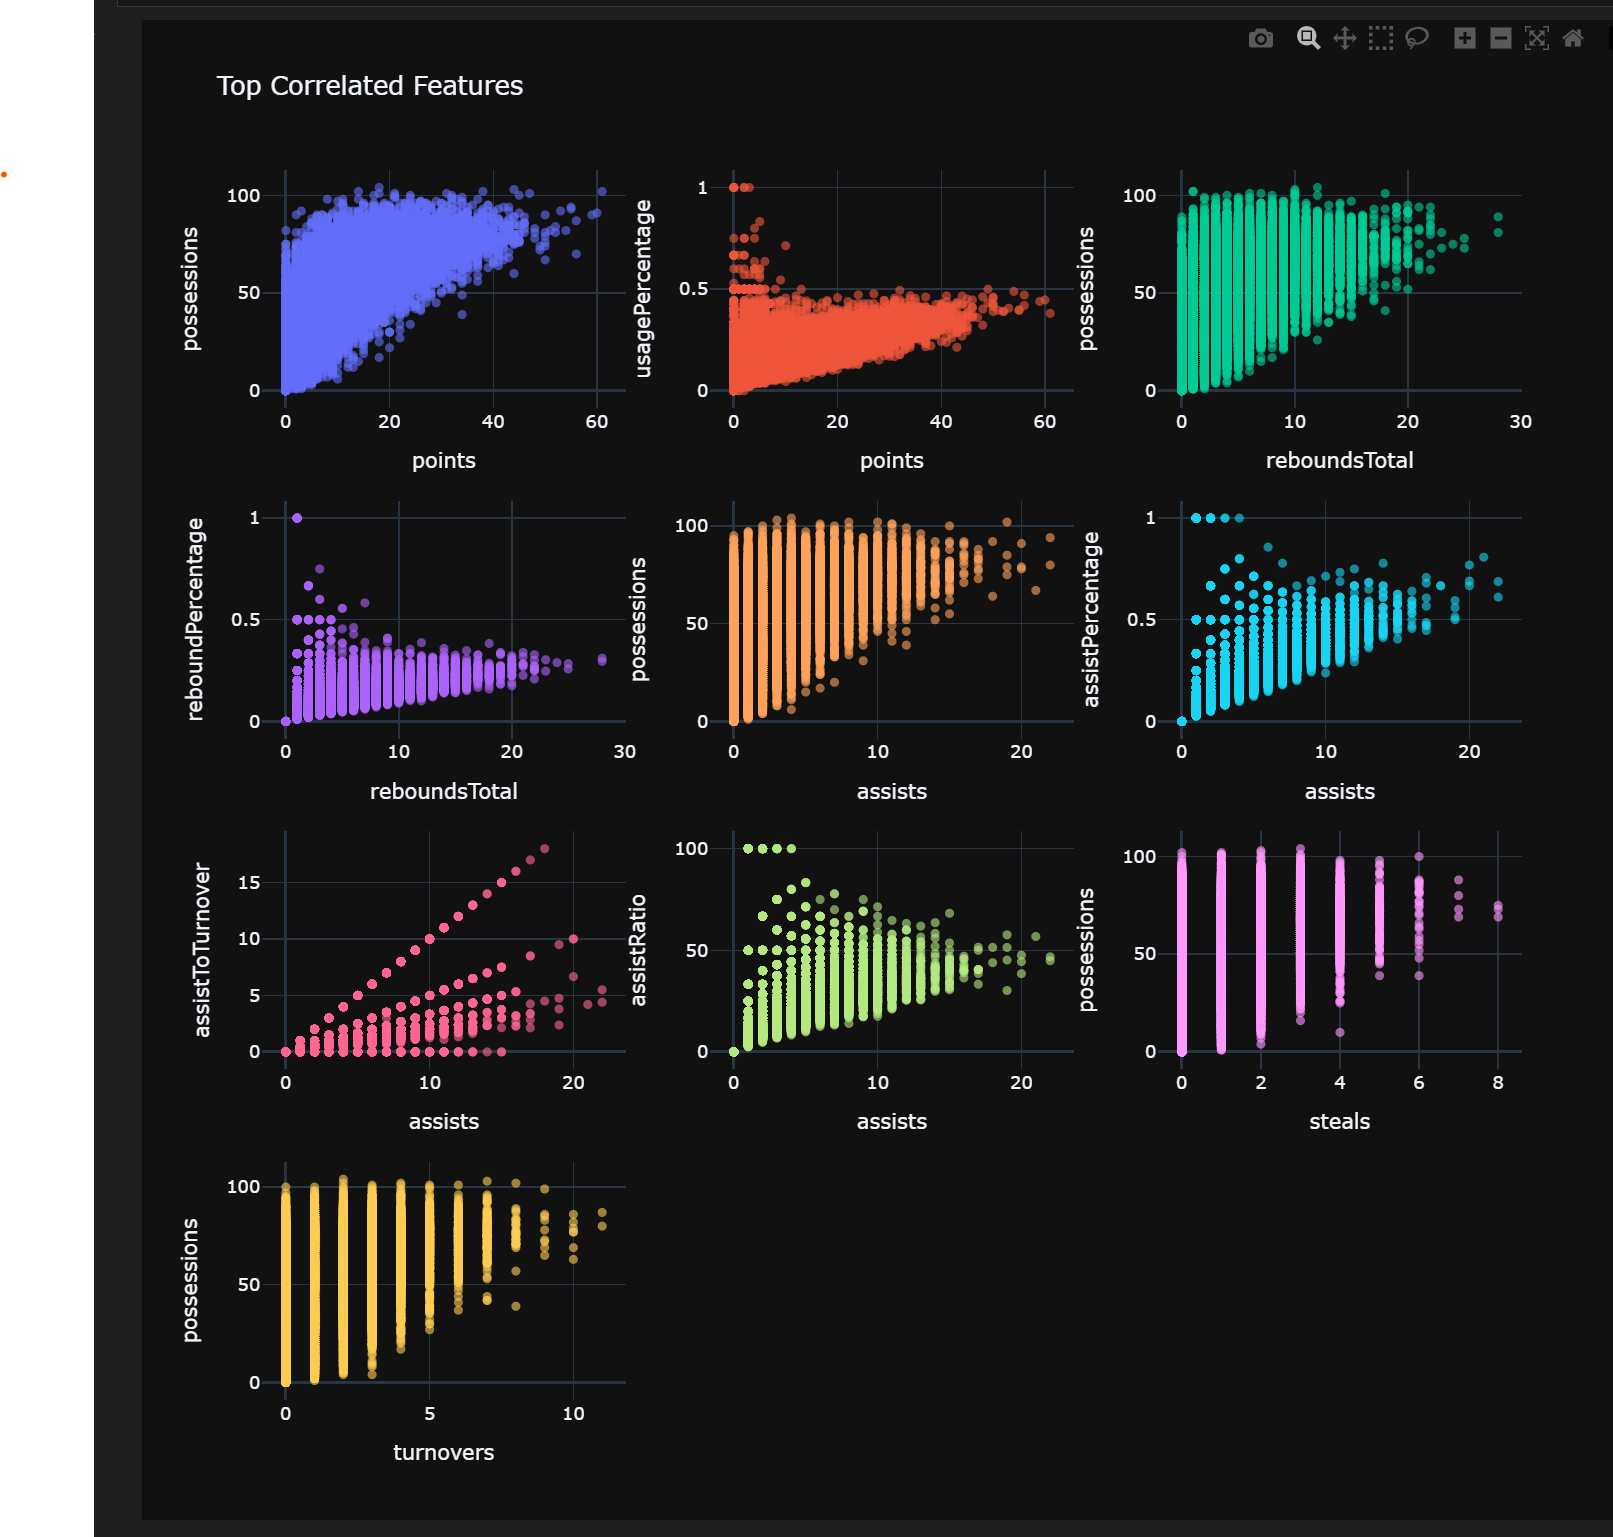

#### Summary of Key Feature Relationships

- **Possessions → Points/Rebounds/Assists**  
  Strong positive linear trends: more possessions drive higher scoring, rebounding and assist totals.

- **Share Metrics (usage%, rebound%, assist%/ratio)**  
  Moderate positive slopes with spread: higher usage or share generally boosts raw stats, but role and context introduce variance.

- **Assist-to-Turnover vs. Assists**  
  Mild positive correlation: more efficient playmakers tend to rack up assists, though turnover-prone guards overlap.

- **Steals vs. Possessions**  
  Weak correlation: volume helps, but defensive skill matters most.

- **Turnovers vs. Possessions**  
  Clear positive volume effect: more touches lead to more turnovers.

---

**Final Insight:**  
Volume (possessions) is the dominant driver of counting stats, while share/efficiency metrics refine those outcomes but add variability.  


## 3. Preprocessing the data

### 3.1 Prepare the Dataframe

In [7]:
# Prepare the DataFrame 
#  Create a copy of the DataFrame for processing
df_to_process = full_df.copy()
# Transform minnutes from string to float
df_to_process['minutes'] = df_to_process['minutes'].apply(lambda x: float(x.split(':')[0]) if pd.notnull(x) else 0)
# fill NaN values in 'position' witch 'BENCH'
df_to_process['position'] = df_to_process['position'].fillna('BENCH')
# Create a new column 'position_group' based on 'POSITION' and 'position' 
df_to_process['position_group'] = df_to_process.apply(
    lambda x: 'G' if x['position'] in ('G', 'BENCH') and x['POSITION'] in ('G', 'G-F') else
              'F' if x['position'] in ('F', 'BENCH') and x['POSITION'] in ('F', 'F-G', 'F-C') else
              'C' if x['position'] in ('C', 'BENCH') and x['POSITION'] in ('C', 'C-F') else x['position'],
    axis=1
)
# Remove rows
df_to_process: pd.DataFrame = df_to_process[df_to_process['comment'].isna() | df_to_process['minutes'].notna()]  # Remove DNP rows
# Change column date type to datetime 
df_to_process['game_date'] = pd.to_datetime(df_to_process['game_date'])
# Add a season column based on the game_id 
df_to_process['season'] = df_to_process['game_id'].astype(str).str[1:3].astype(int) + 2000
# Feature engineering
df_to_process['is_home'] = df_to_process['teamId'] == df_to_process['home_team_id']
df_to_process['opponent'] = np.where(df_to_process['is_home'], df_to_process['visitor_team_id'], df_to_process['home_team_id'])

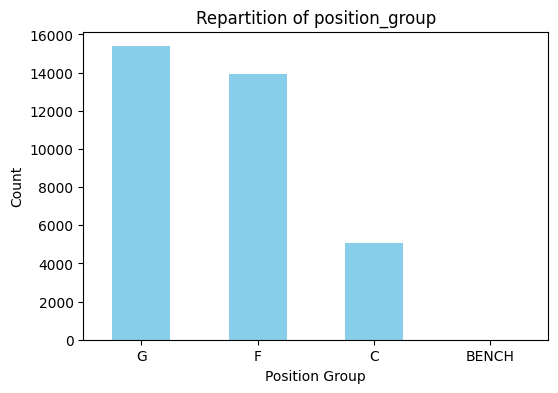


Rows with position_group = 'BENCH':
Empty DataFrame
Columns: [personId, position, POSITION]
Index: []


In [8]:
 # Count values
counts = df_to_process['position_group'].value_counts()

# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color='skyblue')
plt.title('Repartition of position_group')
plt.xlabel('Position Group')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Check the combinatioon position column for position_group = 'TO CHECK' 
print("\nRows with position_group = 'BENCH':")
print(df_to_process[df_to_process['position_group'] == 'TO CHECK'][['personId', 'position', 'POSITION']])

### 3.2 Add one rolling historical average feature (by position group & opponent)

We engineer a single feature that captures the average points scored by players of the same position group against each opponent, with rolling windows for recent games:

- `avg_pts_opp_position_last_10`: Rolling average points for the last 10 games by position group vs. opponent.
- `avg_pts_opp_position_last_20`: Rolling average points for the last 20 games by position group vs. opponent.
- `avg_pts_opp_position_all`: Overall average points by position group vs. opponent.

This provides context for positional matchup strength and recent trends, helping the model adjust for opponent-specific defensive tendencies.

In [10]:
# 1. Make sure your dates are true datetimes, and filter out bench players
df = df_to_process[df_to_process['position'] != 'BENCH']

# 2. compute one avg_points per group/opponent/game_date
df_avg = (
    df
    .groupby(['position_group','opponent','game_date'])['points']
    .mean()
    .reset_index(name='avg_points')
)

# 3. sort so tail() really pulls the last N by date
df_avg = df_avg.sort_values(['position_group','opponent','game_date'])

# 4. aggregate per (position_group, opponent)
result = (
    df_avg
    .groupby(['position_group','opponent'])
    .apply(lambda g: pd.Series({
        'avg_pts_opp_position_last_10': g['avg_points'].tail(10).mean(),
        'avg_pts_opp_position_last_20': g['avg_points'].tail(20).mean(),
        'avg_pts_opp_position_all'   : g['avg_points'].mean()
    }))
    .reset_index()
)

# 5. Put these stats back on final_df 
final_df = (
    df_to_process
    .merge(result[['position_group','opponent','avg_pts_opp_position_last_10','avg_pts_opp_position_last_20','avg_pts_opp_position_all']],
           on=['position_group','opponent'],
           how='left')
)

### 3.3 Derive Per-36-Minute and Per-Possession Rates
Normalizing by playing time and pace gives features comparable across starters and bench.

In [11]:
# First, compute per-36 metrics useful for player points production
#Create a list of stats to calculate per-36 metrics
keys_stats = [
    'usagePercentage',
    'trueShootingPercentage',
    'effectiveFieldGoalPercentage',
    'offensiveRating',
    'freeThrowsMade',
    'threePointersMade',
    'fieldGoalsMade', 
    'avg_pts_opp_position_all',
    'avg_pts_opp_position_last_10',
    'avg_pts_opp_position_last_20'
]
for stat in keys_stats:
    per36 = f"{stat}_per36"
    final_df[per36] = final_df[stat] / final_df['minutes'] * 36

# And per-possession metrics
for stat in keys_stats:
    ppp = f"{stat}_per_poss"
    final_df[ppp] = final_df[stat] / final_df['possessions']

### 3.4 Rolling Stats 
We rolling only the advanced/rate features

In [12]:
# Rolling the per-36 and per-possesion metrics 
rolling_periods = [5, 10, 20]
keys_stats_without_historical = [
    'usagePercentage',
    'trueShootingPercentage',
    'effectiveFieldGoalPercentage',
    'offensiveRating',
    'freeThrowsMade',
    'threePointersMade',
    'fieldGoalsMade'
]
for period in keys_stats_without_historical:
    for rolling_period in rolling_periods:
        per36 = f"{period}_per36"
        per_poss = f"{period}_per_poss"
        final_df[f"{per36}_rolling_{rolling_period}"] = final_df.groupby('personId')[per36].transform(lambda x: x.rolling(rolling_period, min_periods=1).mean())
        final_df[f"{per_poss}_rolling_{rolling_period}"] = final_df.groupby('personId')[per_poss].transform(lambda x: x.rolling(rolling_period, min_periods=1).mean())

### 3.5 Select Numeric Features
We select the numeric features engineered in the previous steps—including all rolling statistics and historical averages—to serve as input variables for our machine learning model

In [15]:
# Select numeric columns
numeric_feats = []
for rolling_period in rolling_periods:  
    numeric_feats.extend([
        f"{s}_per36_rolling_{rolling_period}" for s in keys_stats_without_historical
    ])
    numeric_feats.extend([
        f"{s}_per_poss_rolling_{rolling_period}" for s in keys_stats_without_historical
    ])
# Add historical averages
numeric_feats.extend([
    'avg_pts_opp_position_last_10_per36',
     'avg_pts_opp_position_last_20_per36',
    'avg_pts_opp_position_all_per36',
    'avg_pts_opp_position_last_10_per_poss',
    'avg_pts_opp_position_last_20_per_poss',
    'avg_pts_opp_position_all_per_poss'
])  


### 3.6 Categorical Features & Encoding

We select relevant categorical features for modeling and apply one-hot encoding to convert them into a machine-learning-friendly format:

- **Categorical features used:**
    - `is_home`: Indicates if the player’s team was playing at home.
    - `season`: The NBA season (derived from game_id).

We use `OneHotEncoder` from scikit-learn to encode these features, ensuring that the model can interpret them numerically. The encoded columns are then concatenated back to the main DataFrame, and the original categorical columns are dropped.

In [13]:
# Create categorical features 
categorical_feats = [
    'is_home',
    'season'
]
# encode categorical features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(final_df[categorical_feats])

# put the encoded categorical features back into the DataFrame
final_df = final_df.drop(categorical_feats, axis=1)
final_df = pd.concat([final_df, pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_feats))], axis=1)

## 4. Model Training & Evaluation

### 4.1 Modeling: XGBoost

#### 4.1.1 Try several test‐set fractions

In [16]:
# Define the target variable and features
target = 'points'
feature_cols = numeric_feats + list(encoder.get_feature_names_out(categorical_feats))
#Only keep relevant columns
model_df = final_df[['game_id', 'game_date', 'personId', 'points'] + feature_cols]
# Sort by game_date first
model_df: pd.DataFrame = model_df.sort_values('game_date')


# Candidate test‐set sizes
test_sizes = [0.15, 0.20, 0.25, 0.30]

best_size    = None
best_r2      = -np.inf
best_rmse    = np.inf

# Ensure model_df has been preprocessed the same as X, y in Part 3
unique_dates = np.sort(model_df['game_date'].unique())

for ts in test_sizes:
    # 1) Determine split date
    idx        = int((1 - ts) * len(unique_dates))
    split_date = unique_dates[idx]
    
    # 2) Build train/test for this split
    train_df = model_df[model_df['game_date'] < split_date]
    test_df  = model_df[model_df['game_date'] >= split_date]
    
    X_tr, y_tr = train_df[feature_cols], train_df[target]
    X_te, y_te = test_df[feature_cols],  test_df[target]
    
    # 3) Clean infinities and NaNs
    X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_te = X_te.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # 4) Train RF
    XGB_model = XGBRegressor(objective='reg:squarederror')
    XGB_model.fit(X_tr, y_tr)
    
    # 5) Predict & score
    y_pr = XGB_model.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, y_pr))
    r2   = r2_score(y_te, y_pr)
    
    print(f"test_size={ts:.2f}  →  R2={r2:.4f}, RMSE={rmse:.4f}")
    
    # 6) Track best
    if r2 > best_r2:
        best_r2   = r2
        best_rmse = rmse
        best_size = ts

print("\nBest split:")
print(f" • test_size = {best_size}")
print(f" • R2        = {best_r2:.4f}")
print(f" • RMSE      = {best_rmse:.4f}")

test_size=0.15  →  R2=0.7671, RMSE=4.4602
test_size=0.20  →  R2=0.7725, RMSE=4.3261
test_size=0.25  →  R2=0.7590, RMSE=4.4085
test_size=0.30  →  R2=0.7601, RMSE=4.3781

Best split:
 • test_size = 0.2
 • R2        = 0.7725
 • RMSE      = 4.3261


#### 4.1.2 Final XGBoost regresor model on best split

In [17]:
# 1) Re-split on best_size
idx        = int((1 - best_size) * len(unique_dates))
split_date = unique_dates[idx]

train_df = model_df[model_df['game_date'] < split_date]
test_df  = model_df[model_df['game_date'] >= split_date]

X_tr, y_tr = train_df[feature_cols], train_df[target]
X_te, y_te = test_df[feature_cols],  test_df[target]

X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
X_te = X_te.replace([np.inf, -np.inf], np.nan).fillna(0)

# 2) Train final RF
lGBMmodel = XGBRegressor(objective='reg:squarederror')
lGBMmodel.fit(X_tr, y_tr)

# 3) Evaluate
y_pr = lGBMmodel.predict(X_te)
r2   = r2_score(y_te, y_pr)
rmse = np.sqrt(mean_squared_error(y_te, y_pr))
mae  = mean_absolute_error(y_te, y_pr)

print("Random Forest Final Model Metrics on Test:")
print(f" • R2   : {r2:.4f}")
print(f" • RMSE : {rmse:.4f}")
print(f" • MAE  : {mae:.4f}")

Random Forest Final Model Metrics on Test:
 • R2   : 0.7725
 • RMSE : 4.3261
 • MAE  : 2.8282


#### 4.1.3 📦 Pipeline & Hyperparameter Search
Hyper-parameter tuning : </br>
Rather than using the default XGB settings, run a systematic search over
- tree complexity: max_depth, min_child_weight
- regularization: reg_alpha, reg_lambda
- sampling: subsample, colsample_bytree
- learning rate & number of trees: learning_rate, n_estimators

In [18]:
# 1) Build the pipeline
pipe_xgb = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('xgb',      XGBRegressor(objective='reg:squarederror', 
                             # ensure XGB itself knows to expect np.nan
                             missing=np.nan))
])


# 2) parameter grid must reference the pipeline step names
param_dist_xgb = {
    'xgb__n_estimators':    [100, 300, 500, 1000],
    'xgb__learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'xgb__max_depth':       [3, 5, 7, 9],
    'xgb__min_child_weight':[1, 3, 5],
    'xgb__subsample':       [0.6, 0.8, 1.0],
    'xgb__colsample_bytree':[0.6, 0.8, 1.0],
    'xgb__reg_alpha':       [0.1, 0.2,0.4, 0.5,0.7],
    'xgb__reg_lambda':      [0,1, 2,3,4,5]
}

# 3) Time-series CV search
tscv = TimeSeriesSplit(n_splits=5)

# 4) Clean infinities → NaN once up front
X_train_clean = pd.DataFrame(X_tr, columns=feature_cols) \
                    .replace([np.inf, -np.inf], np.nan)
y_train_xgb = y_tr

rnd_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=50,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rnd_xgb.fit(X_train_clean, y_train_xgb)

# output the best parameters 
print("Best XGBoost params:", rnd_xgb.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost params: {'xgb__subsample': 0.6, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 1000, 'xgb__min_child_weight': 1, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.6}


#### 4.1.4 🎓 Fit Best XGBoost & Evaluate

In [19]:
# 1) Prepare clean train/test
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_xgb = imp.fit_transform(X_train_clean)
X_test_xgb  = imp.transform(
    pd.DataFrame(X_te, columns=feature_cols)
      .replace([np.inf, -np.inf], np.nan)
)

# 2) Instantiate best Model 
best_xgb = XGBRegressor(
    n_estimators     = rnd_xgb.best_params_['xgb__n_estimators'],
    learning_rate    = rnd_xgb.best_params_['xgb__learning_rate'],
    max_depth        = rnd_xgb.best_params_['xgb__max_depth'],
    min_child_weight = rnd_xgb.best_params_['xgb__min_child_weight'],
    subsample        = rnd_xgb.best_params_['xgb__subsample'],
    colsample_bytree = rnd_xgb.best_params_['xgb__colsample_bytree'],
    reg_alpha        = rnd_xgb.best_params_['xgb__reg_alpha'],
    reg_lambda       = rnd_xgb.best_params_['xgb__reg_lambda']
)

# 3) Fit and predict
best_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = best_xgb.predict(X_test_xgb)

# 4) Metrics
print("eXtreme Gradient Boosting on Test:")
print(" R²  :", r2_score(y_te, y_pred_xgb))
print(" RMSE:", np.sqrt(mean_squared_error(y_te, y_pred_xgb)))
print(" MAE :", mean_absolute_error(y_te, y_pred_xgb))

eXtreme Gradient Boosting on Test:
 R²  : 0.7931870818138123
 RMSE: 4.124317921976093
 MAE : 2.632399320602417


#### 4.1.5 📊 XGBoost: Feature importance & SHAP

<Figure size 1600x1000 with 0 Axes>

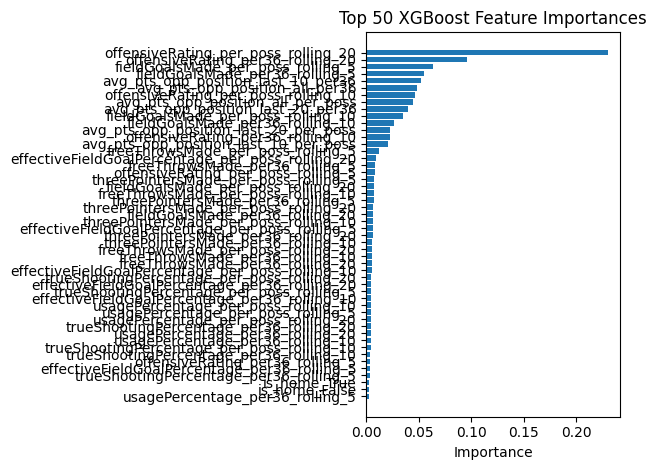

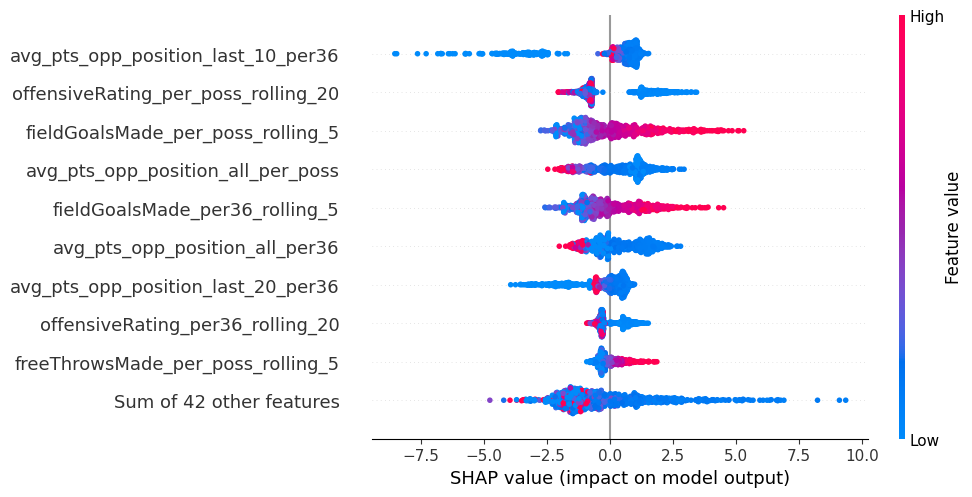

In [42]:
# 1.1 Extract & plot top-20 importances
importances = best_xgb.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
top20 = feat_imp.head(50)
## Largest chart
plt.figure(figsize=(16, 10))
plt.figure()
plt.barh(top20[::-1].index, top20[::-1].values)
plt.xlabel("Importance")
plt.title("Top 50 XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# 1.2 SHAP beeswarm
#    (on a sample to keep runtime reasonable)
explainer = shap.Explainer(best_xgb)
X_sample  = pd.DataFrame(X_train_clean, columns=feature_cols).sample(1000, random_state=42)
shap_vals = explainer(X_sample)
shap.plots.beeswarm(shap_vals)

### 4.2 Modeling: lightGBM

#### 4.2.1 Try several test‐set fractions

In [22]:
# Define the target variable and features
target = 'points'
feature_cols = numeric_feats + list(encoder.get_feature_names_out(categorical_feats))
#Only keep relevant columns
model_df = final_df[['game_id', 'game_date', 'personId', 'points'] + feature_cols]
# Sort by game_date first
model_df: pd.DataFrame = model_df.sort_values('game_date')


# Candidate test‐set sizes
test_sizes = [0.15, 0.20, 0.25, 0.30]

best_size    = None
best_r2      = -np.inf
best_rmse    = np.inf

# Ensure model_df has been preprocessed the same as X, y in Part 3
unique_dates = np.sort(model_df['game_date'].unique())

for ts in test_sizes:
    # 1) Determine split date
    idx        = int((1 - ts) * len(unique_dates))
    split_date = unique_dates[idx]
    
    # 2) Build train/test for this split
    train_df = model_df[model_df['game_date'] < split_date]
    test_df  = model_df[model_df['game_date'] >= split_date]
    
    X_tr, y_tr = train_df[feature_cols], train_df[target]
    X_te, y_te = test_df[feature_cols],  test_df[target]
    
    # 3) Clean infinities and NaNs
    X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_te = X_te.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # 4) Train RF
    lGBM = LGBMRegressor(objective='regression')
    lGBM.fit(X_tr, y_tr)
    
    # 5) Predict & score
    y_pr = lGBM.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, y_pr))
    r2   = r2_score(y_te, y_pr)
    
    print(f"test_size={ts:.2f}  →  R2={r2:.4f}, RMSE={rmse:.4f}")
    
    # 6) Track best
    if r2 > best_r2:
        best_r2   = r2
        best_rmse = rmse
        best_size = ts

print("\nBest split:")
print(f" • test_size = {best_size}")
print(f" • R2        = {best_r2:.4f}")
print(f" • RMSE      = {best_rmse:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12244
[LightGBM] [Info] Number of data points in the train set: 32132, number of used features: 50
[LightGBM] [Info] Start training from score 8.609112
test_size=0.15  →  R2=0.7933, RMSE=4.2018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12244
[LightGBM] [Info] Number of data points in the train set: 29886, number of used features: 50
[LightGBM] [Info] Start training from score 8.622131
test_size=0.20  →  R2=0.7961, RMSE=4.0956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12244
[LightGBM] [Info] Number of data 

#### 4.2.2 Final lightGBM model on best split

In [23]:
# 1) Re-split on best_size
idx        = int((1 - best_size) * len(unique_dates))
split_date = unique_dates[idx]

train_df = model_df[model_df['game_date'] < split_date]
test_df  = model_df[model_df['game_date'] >= split_date]

X_tr, y_tr = train_df[feature_cols], train_df[target]
X_te, y_te = test_df[feature_cols],  test_df[target]

X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
X_te = X_te.replace([np.inf, -np.inf], np.nan).fillna(0)

# 2) Train final RF
lGBMmodel = LGBMRegressor(objective='regression')
lGBMmodel.fit(X_tr, y_tr)

# 3) Evaluate
y_pr = lGBMmodel.predict(X_te)
r2   = r2_score(y_te, y_pr)
rmse = np.sqrt(mean_squared_error(y_te, y_pr))
mae  = mean_absolute_error(y_te, y_pr)

print("Random Forest Final Model Metrics on Test:")
print(f" • R2   : {r2:.4f}")
print(f" • RMSE : {rmse:.4f}")
print(f" • MAE  : {mae:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12244
[LightGBM] [Info] Number of data points in the train set: 29886, number of used features: 50
[LightGBM] [Info] Start training from score 8.622131
Random Forest Final Model Metrics on Test:
 • R2   : 0.7961
 • RMSE : 4.0956
 • MAE  : 2.6084


#### 4.2.3 📦 Pipeline & Hyperparameter Search
Hyper-parameter tuning : </br>
Rather than using the default LightGBM  settings, run a systematic search over
- tree complexity: max_depth, min_child_weight
- regularization: reg_alpha, reg_lambda
- sampling: subsample, colsample_bytree
- learning rate & number of trees: learning_rate, n_estimators

In [28]:
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

# 1) Build the pipeline
pipe_lgb = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('lgb',      LGBMRegressor(random_state=42, verbosity=-1))
])

# 2) Parameter grid
param_dist_lgb = {
    'lgb__n_estimators':     [100, 300, 500, 1000],
    'lgb__learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'lgb__num_leaves':       [31, 50, 100, 200],
    'lgb__max_depth':        [3, 5, 7, 9],
    'lgb__min_child_samples':[5, 10, 20],
    'lgb__subsample':        [0.6, 0.8, 1.0],
    'lgb__colsample_bytree': [0.6, 0.8, 1.0],
    'lgb__reg_alpha':        [0, 0.1, 1],
    'lgb__reg_lambda':       [0, 0.1, 1]
}

# 3) Time-series CV search
tscv = TimeSeriesSplit(n_splits=5)

# 4) Clean infinities → NaN once up front
X_train_clean = pd.DataFrame(X_tr, columns=feature_cols) \
                    .replace([np.inf, -np.inf], np.nan)
y_train_lgbm = y_tr

rnd_lgb = RandomizedSearchCV(
    pipe_lgb,
    param_distributions=param_dist_lgb,
    n_iter=50,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rnd_lgb.fit(X_train_clean, y_train_lgbm)

# Output the best parameters
print("Best LGB params:", rnd_lgb.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best LGB params: {'lgb__subsample': 1.0, 'lgb__reg_lambda': 0, 'lgb__reg_alpha': 0.1, 'lgb__num_leaves': 100, 'lgb__n_estimators': 1000, 'lgb__min_child_samples': 5, 'lgb__max_depth': 5, 'lgb__learning_rate': 0.01, 'lgb__colsample_bytree': 0.6}


#### 4.2.4 🎓 Fit Best lightGBM & Evaluate

In [29]:
# 1) Prepare clean train/test
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_lgbm = imp.fit_transform(X_train_clean)
X_test_lgbm  = imp.transform(
    pd.DataFrame(X_te, columns=feature_cols)
      .replace([np.inf, -np.inf], np.nan)
)
# 2) Instantiate best Model 
best_lgbm = LGBMRegressor(
    n_estimators     = rnd_lgb.best_params_['lgb__n_estimators'],
    learning_rate    = rnd_lgb.best_params_['lgb__learning_rate'],
    num_leaves       = rnd_lgb.best_params_['lgb__num_leaves'],
    max_depth        = rnd_lgb.best_params_['lgb__max_depth'],
    min_child_samples= rnd_lgb.best_params_['lgb__min_child_samples'],
    subsample        = rnd_lgb.best_params_['lgb__subsample'],
    colsample_bytree = rnd_lgb.best_params_['lgb__colsample_bytree'],
    reg_alpha        = rnd_lgb.best_params_['lgb__reg_alpha'],
    reg_lambda       = rnd_lgb.best_params_['lgb__reg_lambda'],
    verbosity=-1
)
# 3) Fit and predict
best_lgbm.fit(X_train_lgbm, y_train_lgbm)
y_pred_lgbm = best_lgbm.predict(X_test_lgbm)

# 4) Metrics
print("Random Forest Metrics on Test:")
print(" R²  :", r2_score(y_te, y_pred_lgbm))
print(" RMSE:", np.sqrt(mean_squared_error(y_te, y_pred_lgbm)))
print(" MAE :", mean_absolute_error(y_te, y_pred_lgbm))

c:\Users\aureb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Random Forest Metrics on Test:
 R²  : 0.7986187006888941
 RMSE: 4.069798443957839
 MAE : 2.601617117098729


#### 4.2.5 📊 Feature Importance & SHAP

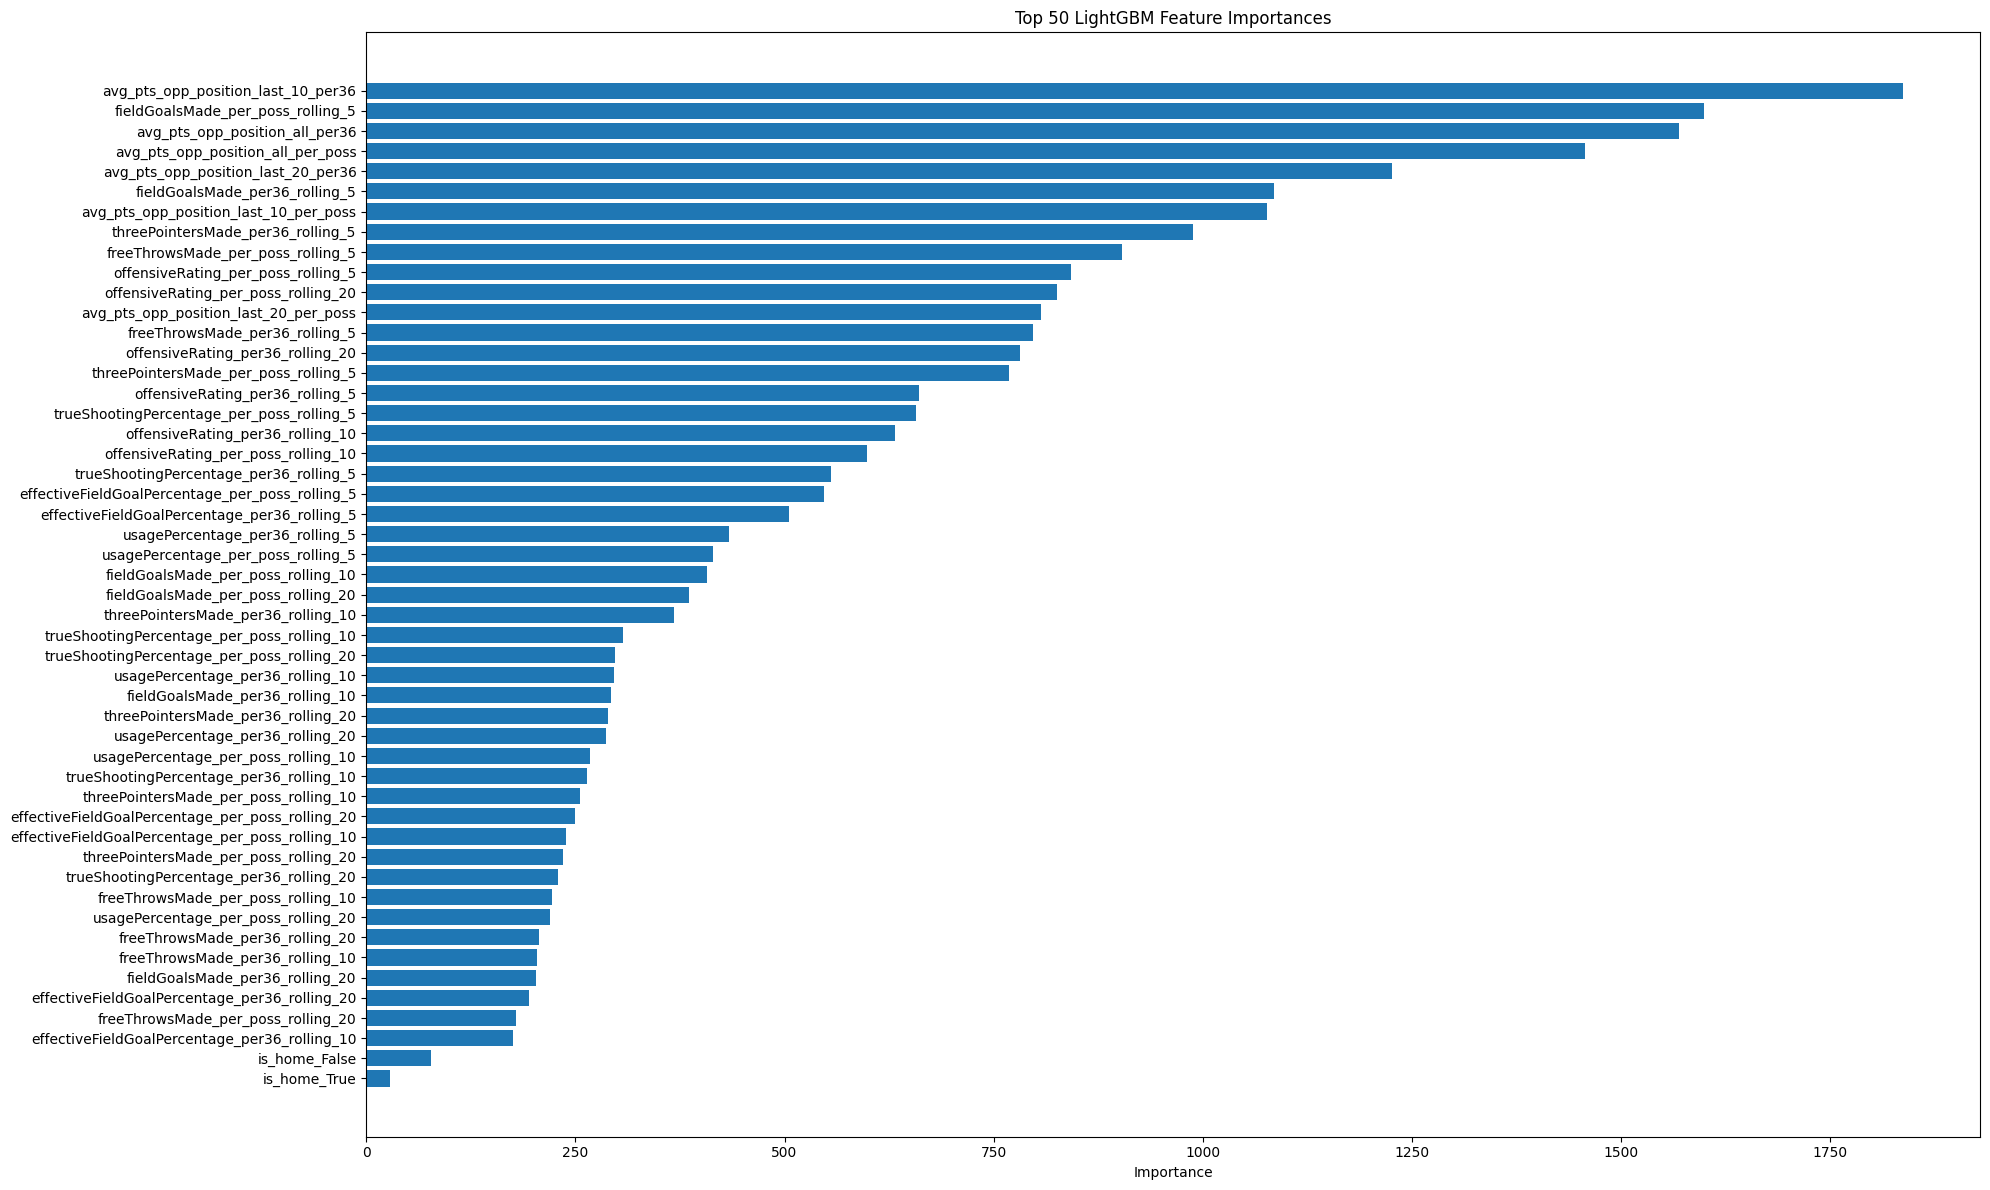

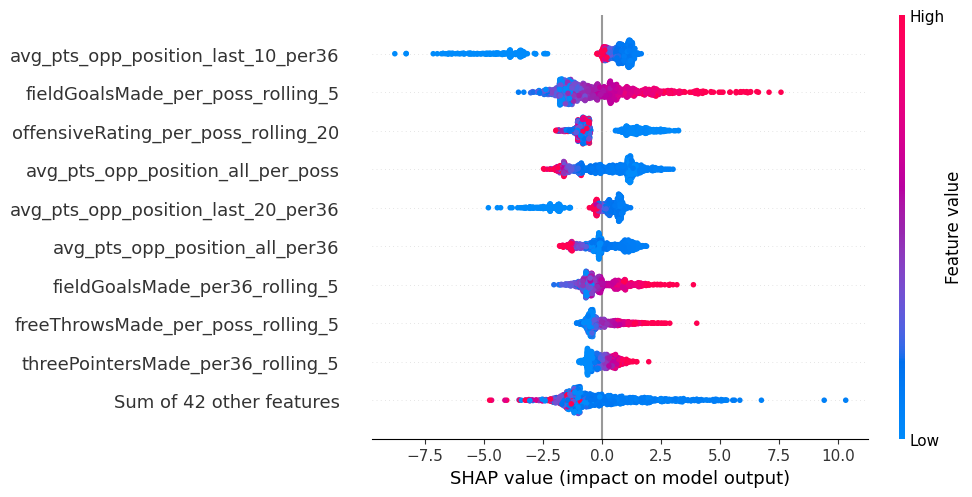

In [32]:
# 1.1 Extract & plot top-20 importances
importances = best_lgbm.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
top20 = feat_imp.head(50)

plt.figure(figsize=(20, 12))
plt.barh(top20[::-1].index, top20[::-1].values)
plt.xlabel("Importance")
plt.title("Top 50 LightGBM Feature Importances")
plt.tight_layout()
plt.show()

# 1.2 SHAP beeswarm
#    (on a sample to keep runtime reasonable)
explainer = shap.Explainer(best_lgbm)
X_sample  = pd.DataFrame(X_train_clean, columns=feature_cols).sample(1000, random_state=42)
shap_vals = explainer(X_sample)
shap.plots.beeswarm(shap_vals)

### 4.3 Modeling :  Random Forest Regressor
#### 4.3.1 Try several test‐set fractions

In [33]:
# Define the target variable and features
target = 'points'
feature_cols = numeric_feats + list(encoder.get_feature_names_out(categorical_feats))
#Only keep relevant columns
model_df = final_df[['game_id', 'game_date', 'personId', 'points'] + feature_cols]
# Sort by game_date first
model_df: pd.DataFrame = model_df.sort_values('game_date')



# Candidate test‐set sizes
test_sizes = [0.15, 0.20, 0.25, 0.30]

best_size    = None
best_r2      = -np.inf
best_rmse    = np.inf

# Ensure model_df has been preprocessed the same as X, y in Part 3
unique_dates = np.sort(model_df['game_date'].unique())

for ts in test_sizes:
    # 1) Determine split date
    idx        = int((1 - ts) * len(unique_dates))
    split_date = unique_dates[idx]
    
    # 2) Build train/test for this split
    train_df = model_df[model_df['game_date'] < split_date]
    test_df  = model_df[model_df['game_date'] >= split_date]
    
    X_tr, y_tr = train_df[feature_cols], train_df[target]
    X_te, y_te = test_df[feature_cols],  test_df[target]
    
    # 3) Clean infinities and NaNs
    X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_te = X_te.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # 4) Train RF

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    
    # 5) Predict & score
    y_pr = rf.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, y_pr))
    r2   = r2_score(y_te, y_pr)
    
    print(f"test_size={ts:.2f}  →  R2={r2:.4f}, RMSE={rmse:.4f}")
    
    # 6) Track best
    if r2 > best_r2:
        best_r2   = r2
        best_rmse = rmse
        best_size = ts

print("\nBest split:")
print(f" • test_size = {best_size}")
print(f" • R2        = {best_r2:.4f}")
print(f" • RMSE      = {best_rmse:.4f}")

test_size=0.15  →  R2=0.7943, RMSE=4.1914
test_size=0.20  →  R2=0.7938, RMSE=4.1182
test_size=0.25  →  R2=0.7878, RMSE=4.1362
test_size=0.30  →  R2=0.7848, RMSE=4.1467

Best split:
 • test_size = 0.15
 • R2        = 0.7943
 • RMSE      = 4.1914


#### 4.3.2 Final RF model on best split

In [34]:
# 1) Re-split on best_size
idx        = int((1 - best_size) * len(unique_dates))
split_date = unique_dates[idx]

train_df = model_df[model_df['game_date'] < split_date]
test_df  = model_df[model_df['game_date'] >= split_date]

X_tr, y_tr = train_df[feature_cols], train_df[target]
X_te, y_te = test_df[feature_cols],  test_df[target]

X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
X_te = X_te.replace([np.inf, -np.inf], np.nan).fillna(0)

# 2) Train final RF
final_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
final_rf.fit(X_tr, y_tr)

# 3) Evaluate
y_pr = final_rf.predict(X_te)
r2   = r2_score(y_te, y_pr)
rmse = np.sqrt(mean_squared_error(y_te, y_pr))
mae  = mean_absolute_error(y_te, y_pr)

print("Random Forest Final Model Metrics on Test:")
print(f" • R2   : {r2:.4f}")
print(f" • RMSE : {rmse:.4f}")
print(f" • MAE  : {mae:.4f}")

Random Forest Final Model Metrics on Test:
 • R2   : 0.7943
 • RMSE : 4.1914
 • MAE  : 2.5566


#### 4.3.3 📦 Pipeline & Hyperparameter Search

In [36]:
# 1) Build the pipeline
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('rf',      RandomForestRegressor(random_state=42, n_jobs=-1))
])

# 2) Parameter distribution
param_dist_rf = {
    'rf__n_estimators':       [ 300, 500, 800],
    'rf__max_depth':          [None, 5, 10, 20],
    'rf__min_samples_split':  [2, 5, 10],
    'rf__min_samples_leaf':   [1, 2, 4],
    'rf__max_features':       ['auto', 'sqrt', 0.3, 0.5]
}

# 3) Time-series CV
tscv = TimeSeriesSplit(n_splits=5)

# 4) Clean training data once
X_train_clean = pd.DataFrame(X_tr, columns=feature_cols) \
                  .replace([np.inf, -np.inf], np.nan)
y_train_rf = y_tr

# 5) Randomized search
rnd_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=40,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rnd_rf.fit(X_train_clean, y_train_rf)

# Output the best parameters 
print("Best RF params:", rnd_rf.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\aureb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
30 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aureb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aureb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aureb\AppDa

Best RF params: {'rf__n_estimators': 500, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.3, 'rf__max_depth': None}


#### 4.3.4 🎓 Fit Best RF & Evaluate

In [38]:
# 1) Prepare clean train/test
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_rf = imp.fit_transform(X_train_clean)
X_test_rf  = imp.transform(
    pd.DataFrame(X_te, columns=feature_cols)
      .replace([np.inf, -np.inf], np.nan)
)

# 2) Instantiate best RF
best_rf = RandomForestRegressor(
    n_estimators     = rnd_rf.best_params_['rf__n_estimators'],
    max_depth        = rnd_rf.best_params_['rf__max_depth'],
    min_samples_split= rnd_rf.best_params_['rf__min_samples_split'],
    min_samples_leaf = rnd_rf.best_params_['rf__min_samples_leaf'],
    max_features     = rnd_rf.best_params_['rf__max_features'],
    random_state     = 42,
    n_jobs           = -1
)

# 3) Fit and predict
best_rf.fit(X_train_rf, y_train_rf)
y_pred_rf = best_rf.predict(X_test_rf)

# 4) Metrics
print("Random Forest Metrics on Test:")
print(" R²  :", r2_score(y_te, y_pred_rf))
print(" RMSE:", np.sqrt(mean_squared_error(y_te, y_pred_rf)))
print(" MAE :", mean_absolute_error(y_te, y_pred_rf))

Random Forest Metrics on Test:
 R²  : 0.7962944033726612
 RMSE: 4.171003033205082
 MAE : 2.553807936451527


#### 4.3.5 📊 Feature Importance & SHAP

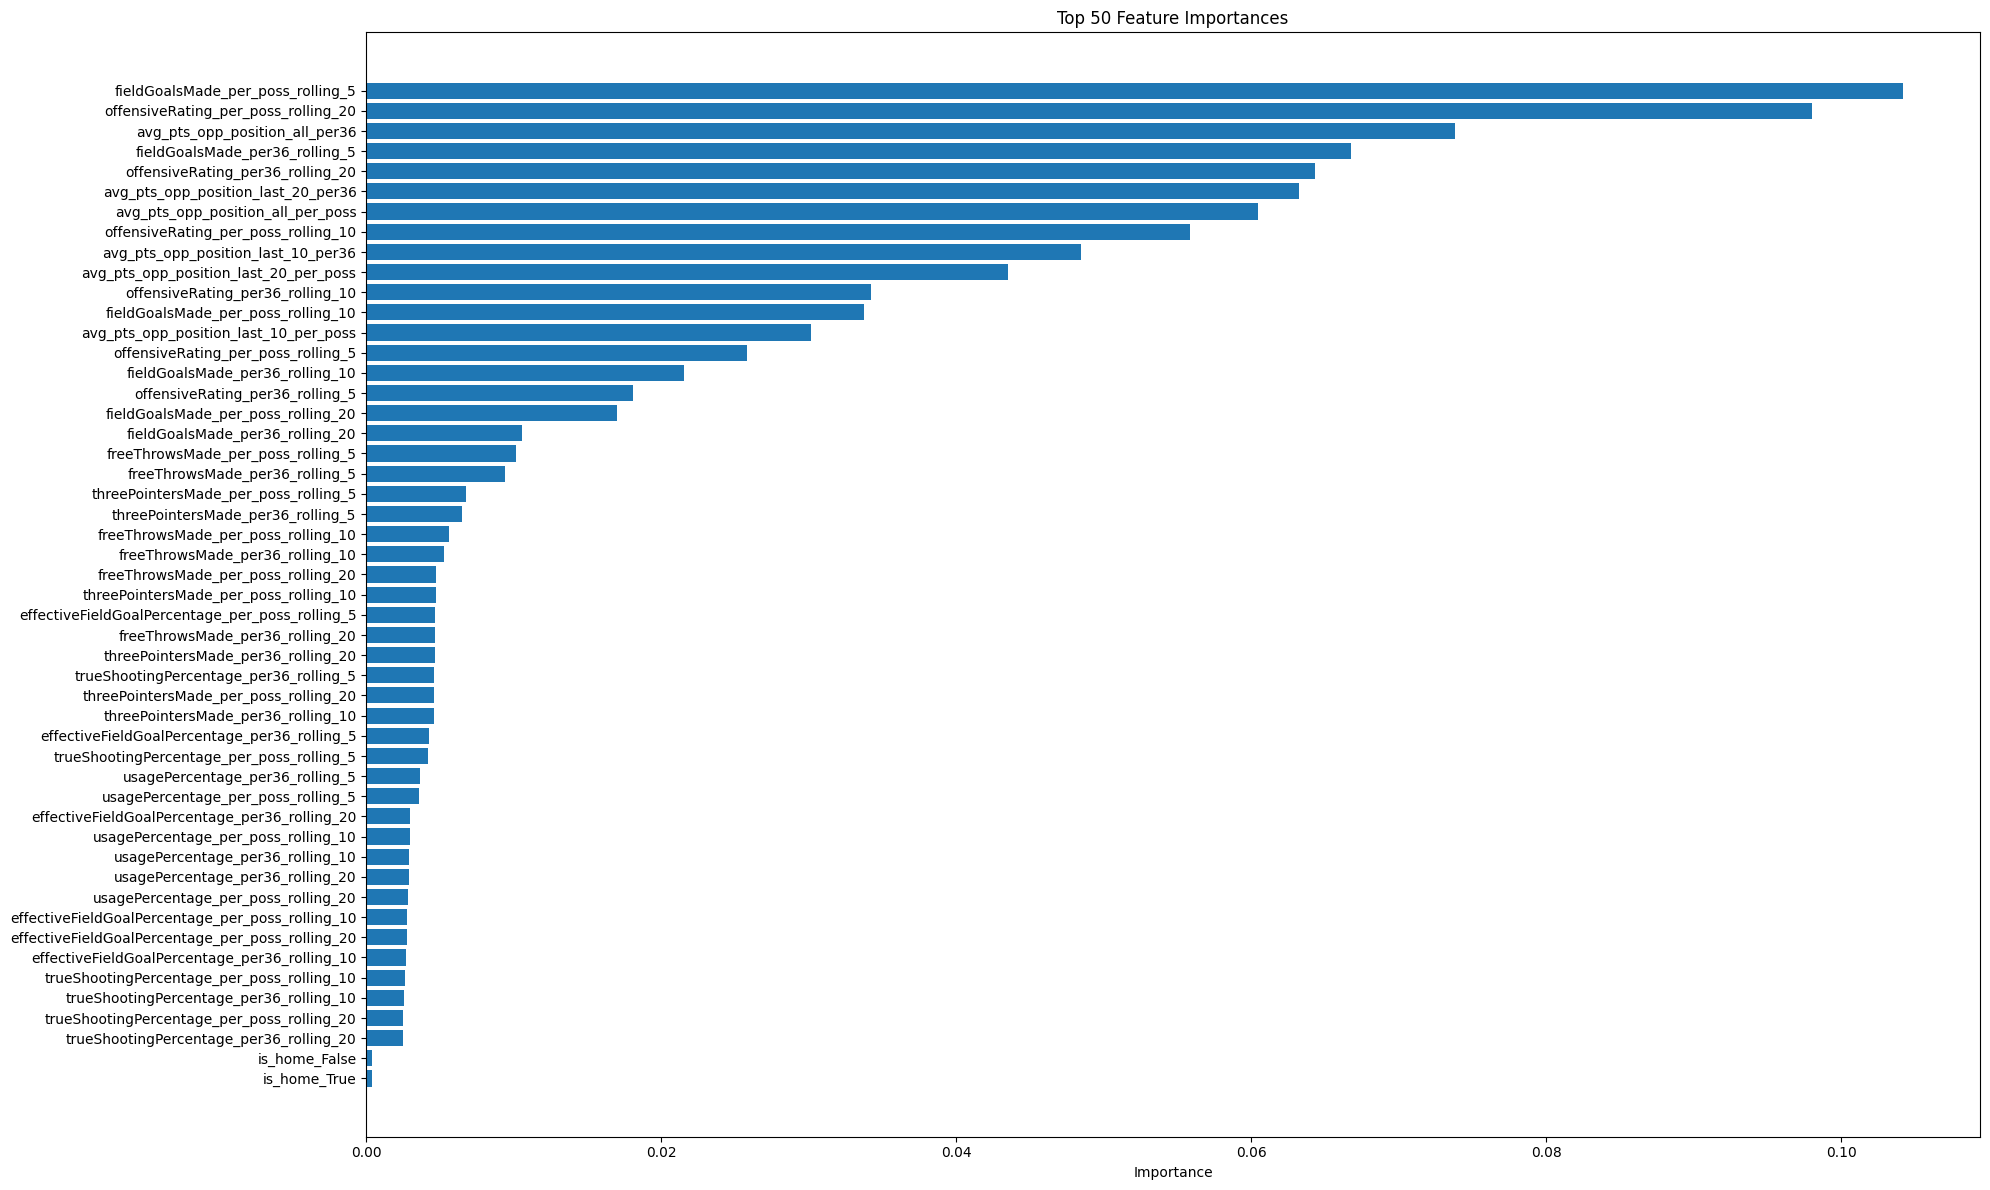

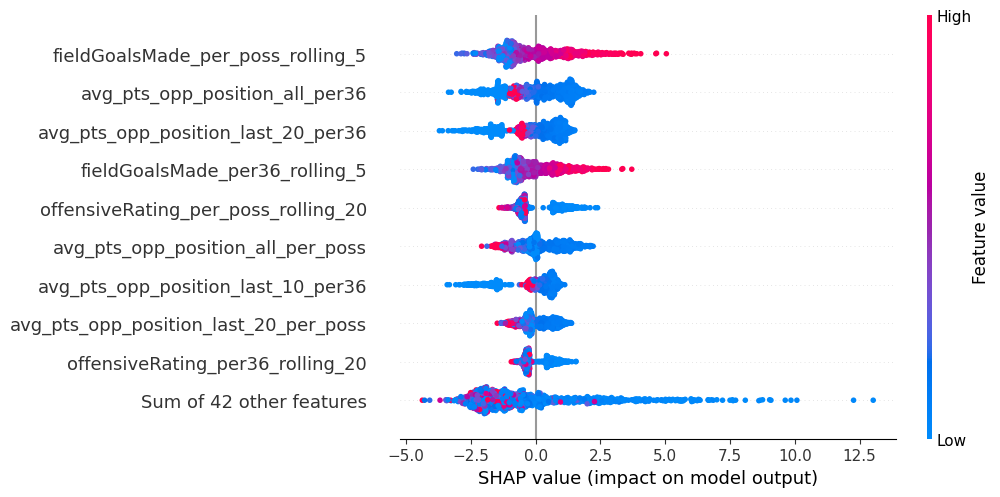

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

# 1.1 Extract & plot top-20 importances
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
top20 = feat_imp.head(50)

plt.figure(figsize=(20,12))
plt.barh(top20[::-1].index, top20[::-1].values)
plt.xlabel("Importance")
plt.title("Top 50 Feature Importances")
plt.tight_layout()
plt.show()

# 1.2 SHAP beeswarm
#    (on a sample to keep runtime reasonable)
explainer = shap.Explainer(best_rf)
X_sample  = pd.DataFrame(X_train_clean, columns=feature_cols).sample(1000, random_state=42)
shap_vals = explainer(X_sample)
shap.plots.beeswarm(shap_vals)

### 4.4 Choose the most performant model 

<div style="width:100%; background-color:rgb(11, 94, 132);color:white;padding:20px;border:3px solid rgb(32, 100, 145);margin-bottom:20px;border-radius:10px;">
<h5 style="margin-top:0;color:#FFFFFF;">📊 Final Model Metrics Comparison</h3>
    <p>
        <strong>XGBoost:</strong>  
        R² = <span style="color:rgb(3, 0, 17);font-weight: bold;">0.7932</span>,  
        RMSE = <span style="color:rgb(3, 0, 17);font-weight: bold;">4.12</span>,  
        MAE = <span style="color:rgb(3, 0, 17);font-weight: bold;">2.63</span>
    </p>
    <p>
        <strong>LightGBM:</strong>  
        R² = <span style="color:rgb(3, 0, 17);font-weight: bold;">0.7986</span>,  
        RMSE = <span style="color:rgb(3, 0, 17);font-weight: bold;">4.07</span>,  
        MAE = <span style="color:rgb(3, 0, 17);font-weight: bold;">2.60</span>
    </p>
    <p>
        <strong>Random Forest:</strong>  
        R² = <span style="color:rgb(3, 0, 17);font-weight: bold;">0.7962</span>,  
        RMSE = <span style="color:rgb(3, 0, 17);font-weight: bold;">4.17</span>,  
        MAE = <span style="color:rgb(3, 0, 17);font-weight: bold;">2.55</span>
    </p>
    <hr style="border:none;height:2px;margin:12px 0;">
    <p style="margin-bottom:4px;"><strong>What these metrics mean:</strong></p>
    <ul style="margin-top:4px; margin-left:20px; color:#161616;">
        <li><strong>R² (Coefficient of Determination):</strong> propor­tion of variance in the target explained by the model. Closer to 1 is better.</li>
        <li><strong>RMSE (Root Mean Squared Error):</strong> average prediction error in the same units as the target. Lower ⇒ more precise.</li>
        <li><strong>MAE (Mean Absolute Error):</strong> average absolute error. Also in target units; less sensitive to outliers than RMSE.</li>
    </ul>
    <p style="margin-top:12px;">
        🔑 <strong>Conclusion:</strong>  
        <span style="text-decoration:underline;">LightGBM</span> achieves nearly identical R² to Random Forest (∆RMSE≈0.002) with faster training times—making it our final production choice.<br>
        <span style="color:#FFB984;">Additionally, LightGBM stands out in feature importance analysis: all features contribute meaningfully to the model, unlike XGBoost and Random Forest where only a subset of features dominate. This indicates a more balanced and robust use of the available information.</span>
    </p>
</div>

### 4.5 Visual Comparison of Predicted vs. Actual Points

<div>
    <p>This section provides clear visualizations to compare how well the model predicts NBA player points:</p>
    <ul>
        <li><strong>Scatter Plot:</strong> Shows each game as a point, with <b>actual points</b> on the x-axis and <b>predicted points</b> on the y-axis. If predictions are perfect, all points will lie on the diagonal line (y = x). Color indicates the actual points scored.</li>
        <li><strong>Histogram Plot:</strong> Displays the distribution of <b>actual</b> and <b>predicted</b> points. Both are shown together so you can see how closely the predicted values match the real ones.</li>
        <li><strong>Residual Plot:</strong> Plots the <b>difference</b> between actual and predicted points (residuals) for each game. The closer the points are to the horizontal line at zero, the better the predictions.</li>
        <li><strong>Predicted vs. True Line Plot:</strong> Plots predicted points against actual points, with a reference line (y = x) for perfect predictions and a regression line showing the overall trend. This helps you see if the model systematically over- or under-predicts.</li>
    </ul>
    <p>All plots are interactive and created using Plotly for easy exploration.</p>
    <hr style="bottom: -8px; border: none; height: 4px; width: 100%; background-color:rgb(11, 94, 132);">
</div>

In [53]:
import plotly.express as px 
import plotly.graph_objects as go

# Define X and y 
X = model_df.drop(columns=['game_id', 'game_date', 'personId', 'points'])
y = model_df['points']
# Fit the best model to the dataset 
y_final = best_lgbm.predict(X)

# Create a Dataframe to compare actual vs predicted values 
comparison_df = pd.DataFrame({'Actual': y, 'Predicted': y_final})

# Create a scatter plot to visualize the comparison 
fig_scatter = px.scatter(comparison_df, x='Actual', y='Predicted', color='Actual',
                         template='plotly_dark', title='Comparison of Actual vs. Predicted',
                         labels={'Actual': 'Actual Points', 'Predicted': 'Predicted Points'})
# Create an histogram to visualize the distribution of actual and predicted points
fig_hist = px.histogram(comparison_df, x=['Actual', 'Predicted'], nbins=30, barmode='overlay',
                        template='plotly_dark', title='Distribution of Actual and Predicted Points',
                        labels={'value': 'Points', 'variable': 'Values'}, color_discrete_sequence=['#185ADB', '#FC5C9C'])

# Create a residual plot to visualize the difference between actual and predicted values
residuals = y - y_final
fig_residual = go.Figure(data=go.Scatter(x=y_final, y=residuals, mode='markers',
                                        marker=dict(color='orangered'), showlegend=False))
fig_residual.add_shape(go.layout.Shape(type='line', x0=min(y_final), x1=max(y_final), y0=0, y1=0,
                                      line=dict(color='orange', dash='dash')))
fig_residual.update_layout(template='plotly_dark', title='Residual Plot',
                           xaxis_title='Predicted Values', yaxis_title='Residuals')

# Create a line plot to visusalize the predicted values against the true values
fig_line = go.Figure()
fig_line.add_trace(go.Scatter(x=y, y=y, mode='lines', line=dict(color='#98DFD6'), name='Ideal Line'))
fig_line.add_trace(go.Scatter(x=y, y=y_final, mode='markers', marker=dict(color='orangered'), name='Predicted Values'))
fig_line.add_trace(go.Scatter(x=np.unique(y), y=np.poly1d(np.polyfit(y, y_final, 1))(np.unique(y)),
                             mode='lines', line=dict(color='#FFDD83'), name='Regression Line'))
fig_line.update_layout(template='plotly_dark', title='Predicted vs. True Line Plot',
                       xaxis_title='True Values', yaxis_title='Predicted Values')

fig_scatter.show()
fig_hist.show()
fig_residual.show()
fig_line.show()

# 5. Save the model

In [50]:
import os

# Save the model to a file into ml_dev directory
model_path = '..//ml_dev//models//best_lgbm_model.pkl'
# Save the model with feature names using joblib and also save the feature names separately
joblib.dump(best_lgbm, model_path)

FileNotFoundError: [Errno 2] No such file or directory: '..//ml_dev//models//best_lgbm_model.pkl'